In [1]:
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras import optimizers
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error

### 데이터 불러오기

In [2]:
dataset=pd.read_csv('data/005930.KS.csv',index_col=0)
dataset=dataset[['Close','Open','High','Low','Volume']]
dataset

,Close,Open,High,Low,Volume
Date,,,,,
2020-04-16,49000.0,49350.0,49350.0,48550.0,23349760
2020-04-17,51400.0,50800.0,52000.0,50300.0,32041675
2020-04-20,50100.0,51400.0,51400.0,50000.0,21866354
2020-04-21,49250.0,49400.0,49700.0,48700.0,27407543
2020-04-22,49850.0,48700.0,50000.0,48350.0,18613864
...,...,...,...,...,...
2021-04-12,83200.0,84100.0,84100.0,83100.0,12915282
2021-04-13,84000.0,83000.0,84500.0,82800.0,15238206
2021-04-14,84000.0,84000.0,84300.0,83400.0,13794652


### LSTM 준비

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i >= 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
#         else:
#             names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### 낮은 RMSE 찾기 위해 lag 조정

In [4]:
rmse_list=[]
n_features=5

for n_days in (3,6,12):

    values = dataset.values
    values = values.astype('float32')

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    reframed = series_to_supervised(scaled, n_days, 1)
    reframed2 = series_to_supervised(scaled, n_days, 1)

    drop_col = list(range(0,n_features*n_days,n_features))+list(range(n_features*n_days+1,n_features*(n_days+1)))

    reframed.drop(reframed.columns[drop_col], axis=1, inplace=True)

    values = reframed.values
    n_train_days = 80
    train = values[:n_train_days, :]
    test = values[n_train_days:, :]

    train_X, train_y = train[:, : -1], train[:, -1]    
    test_X, test_y = test[:, : -1], test[:, -1] 

    train_X = train_X.reshape((train_X.shape[0], n_days, n_features-1))
    test_X = test_X.reshape((test_X.shape[0], n_days, n_features-1))

    learning_rate=0.01
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mae')

    history = model.fit(train_X, train_y, epochs=200, batch_size=16, validation_data=(test_X, test_y), verbose=2, shuffle=False)

    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], n_days*(n_features-1)))

    yhat=yhat[:,0]
    yhat=yhat.reshape(test_X.shape[0],1)

    inv_yhat = np.concatenate((yhat, reframed2.iloc[-(248-n_train_days-n_days):, -4:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]

    test_y=test_y.reshape(test_X.shape[0],1)
    inv_y = np.concatenate((test_y, reframed2.iloc[-(248-n_train_days-n_days):, -4:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]

    yhat=inv_yhat
    test_y=inv_y

    rmse = sqrt(mean_squared_error(test_y, yhat))
    rmse_list.append(round(rmse,3))

Epoch 1/200
5/5 - 8s - loss: 0.0426 - val_loss: 0.1741
Epoch 2/200
5/5 - 0s - loss: 0.0734 - val_loss: 0.1919
Epoch 3/200
5/5 - 0s - loss: 0.0453 - val_loss: 0.1282
Epoch 4/200
5/5 - 0s - loss: 0.0223 - val_loss: 0.0284
Epoch 5/200
5/5 - 0s - loss: 0.0233 - val_loss: 0.0529
Epoch 6/200
5/5 - 0s - loss: 0.0231 - val_loss: 0.0555
Epoch 7/200
5/5 - 0s - loss: 0.0218 - val_loss: 0.0329
Epoch 8/200
5/5 - 0s - loss: 0.0231 - val_loss: 0.0489
Epoch 9/200
5/5 - 0s - loss: 0.0245 - val_loss: 0.0273
Epoch 10/200
5/5 - 0s - loss: 0.0232 - val_loss: 0.0276
Epoch 11/200
5/5 - 0s - loss: 0.0239 - val_loss: 0.0276
Epoch 12/200
5/5 - 0s - loss: 0.0221 - val_loss: 0.0323
Epoch 13/200
5/5 - 0s - loss: 0.0250 - val_loss: 0.0691
Epoch 14/200
5/5 - 0s - loss: 0.0215 - val_loss: 0.0486
Epoch 15/200
5/5 - 0s - loss: 0.0221 - val_loss: 0.0538
Epoch 16/200
5/5 - 0s - loss: 0.0206 - val_loss: 0.0365
Epoch 17/200
5/5 - 0s - loss: 0.0215 - val_loss: 0.0547
Epoch 18/200
5/5 - 0s - loss: 0.0206 - val_loss: 0.0409
E

Epoch 147/200
5/5 - 0s - loss: 0.0170 - val_loss: 0.0668
Epoch 148/200
5/5 - 0s - loss: 0.0163 - val_loss: 0.0688
Epoch 149/200
5/5 - 0s - loss: 0.0160 - val_loss: 0.0713
Epoch 150/200
5/5 - 0s - loss: 0.0163 - val_loss: 0.0771
Epoch 151/200
5/5 - 0s - loss: 0.0164 - val_loss: 0.0821
Epoch 152/200
5/5 - 0s - loss: 0.0176 - val_loss: 0.0730
Epoch 153/200
5/5 - 0s - loss: 0.0162 - val_loss: 0.0869
Epoch 154/200
5/5 - 0s - loss: 0.0163 - val_loss: 0.1099
Epoch 155/200
5/5 - 0s - loss: 0.0169 - val_loss: 0.1103
Epoch 156/200
5/5 - 0s - loss: 0.0185 - val_loss: 0.0745
Epoch 157/200
5/5 - 0s - loss: 0.0175 - val_loss: 0.0982
Epoch 158/200
5/5 - 0s - loss: 0.0162 - val_loss: 0.1389
Epoch 159/200
5/5 - 0s - loss: 0.0166 - val_loss: 0.1004
Epoch 160/200
5/5 - 0s - loss: 0.0159 - val_loss: 0.0890
Epoch 161/200
5/5 - 0s - loss: 0.0157 - val_loss: 0.1087
Epoch 162/200
5/5 - 0s - loss: 0.0163 - val_loss: 0.1338
Epoch 163/200
5/5 - 0s - loss: 0.0183 - val_loss: 0.1371
Epoch 164/200
5/5 - 0s - loss: 

Epoch 93/200
5/5 - 0s - loss: 0.0222 - val_loss: 0.0953
Epoch 94/200
5/5 - 0s - loss: 0.0214 - val_loss: 0.1263
Epoch 95/200
5/5 - 0s - loss: 0.0175 - val_loss: 0.0899
Epoch 96/200
5/5 - 0s - loss: 0.0180 - val_loss: 0.1027
Epoch 97/200
5/5 - 0s - loss: 0.0176 - val_loss: 0.0963
Epoch 98/200
5/5 - 0s - loss: 0.0169 - val_loss: 0.1090
Epoch 99/200
5/5 - 0s - loss: 0.0168 - val_loss: 0.1139
Epoch 100/200
5/5 - 0s - loss: 0.0167 - val_loss: 0.1189
Epoch 101/200
5/5 - 0s - loss: 0.0166 - val_loss: 0.1337
Epoch 102/200
5/5 - 0s - loss: 0.0165 - val_loss: 0.1555
Epoch 103/200
5/5 - 0s - loss: 0.0165 - val_loss: 0.1896
Epoch 104/200
5/5 - 0s - loss: 0.0165 - val_loss: 0.2322
Epoch 105/200
5/5 - 0s - loss: 0.0167 - val_loss: 0.2682
Epoch 106/200
5/5 - 0s - loss: 0.0161 - val_loss: 0.3072
Epoch 107/200
5/5 - 0s - loss: 0.0167 - val_loss: 0.3330
Epoch 108/200
5/5 - 0s - loss: 0.0175 - val_loss: 0.3672
Epoch 109/200
5/5 - 0s - loss: 0.0180 - val_loss: 0.3643
Epoch 110/200
5/5 - 0s - loss: 0.0190 

Epoch 38/200
5/5 - 0s - loss: 0.0189 - val_loss: 0.1138
Epoch 39/200
5/5 - 0s - loss: 0.0184 - val_loss: 0.1179
Epoch 40/200
5/5 - 0s - loss: 0.0197 - val_loss: 0.1154
Epoch 41/200
5/5 - 0s - loss: 0.0188 - val_loss: 0.1036
Epoch 42/200
5/5 - 0s - loss: 0.0198 - val_loss: 0.1204
Epoch 43/200
5/5 - 0s - loss: 0.0185 - val_loss: 0.1330
Epoch 44/200
5/5 - 0s - loss: 0.0189 - val_loss: 0.1322
Epoch 45/200
5/5 - 0s - loss: 0.0184 - val_loss: 0.1128
Epoch 46/200
5/5 - 0s - loss: 0.0185 - val_loss: 0.1165
Epoch 47/200
5/5 - 0s - loss: 0.0193 - val_loss: 0.1045
Epoch 48/200
5/5 - 0s - loss: 0.0185 - val_loss: 0.1218
Epoch 49/200
5/5 - 0s - loss: 0.0186 - val_loss: 0.1080
Epoch 50/200
5/5 - 0s - loss: 0.0184 - val_loss: 0.1206
Epoch 51/200
5/5 - 0s - loss: 0.0183 - val_loss: 0.1102
Epoch 52/200
5/5 - 0s - loss: 0.0181 - val_loss: 0.1185
Epoch 53/200
5/5 - 0s - loss: 0.0181 - val_loss: 0.1048
Epoch 54/200
5/5 - 0s - loss: 0.0185 - val_loss: 0.1048
Epoch 55/200
5/5 - 0s - loss: 0.0187 - val_loss:

Epoch 183/200
5/5 - 0s - loss: 0.0193 - val_loss: 0.0627
Epoch 184/200
5/5 - 0s - loss: 0.0185 - val_loss: 0.0785
Epoch 185/200
5/5 - 0s - loss: 0.0175 - val_loss: 0.0638
Epoch 186/200
5/5 - 0s - loss: 0.0158 - val_loss: 0.0773
Epoch 187/200
5/5 - 0s - loss: 0.0159 - val_loss: 0.0658
Epoch 188/200
5/5 - 0s - loss: 0.0159 - val_loss: 0.0684
Epoch 189/200
5/5 - 0s - loss: 0.0153 - val_loss: 0.0763
Epoch 190/200
5/5 - 0s - loss: 0.0153 - val_loss: 0.0889
Epoch 191/200
5/5 - 0s - loss: 0.0148 - val_loss: 0.1015
Epoch 192/200
5/5 - 0s - loss: 0.0146 - val_loss: 0.0857
Epoch 193/200
5/5 - 0s - loss: 0.0154 - val_loss: 0.0783
Epoch 194/200
5/5 - 0s - loss: 0.0161 - val_loss: 0.0756
Epoch 195/200
5/5 - 0s - loss: 0.0150 - val_loss: 0.0967
Epoch 196/200
5/5 - 0s - loss: 0.0145 - val_loss: 0.0966
Epoch 197/200
5/5 - 0s - loss: 0.0141 - val_loss: 0.0845
Epoch 198/200
5/5 - 0s - loss: 0.0144 - val_loss: 0.0844
Epoch 199/200
5/5 - 0s - loss: 0.0139 - val_loss: 0.0835
Epoch 200/200
5/5 - 0s - loss: 

In [5]:
rmse_list

[14566.196, 11034.222, 4674.12]

=> n_days = 12

### 낮은 RMSE 찾기 위해 epochs, batch_size 조정

In [6]:
rmse_list=[]
n_days=12

for i in (50, 100, 150, 200, 250):
    for j in (1, 8, 16, 64):
        values = dataset.values
        values = values.astype('float32')

        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(values)

        reframed = series_to_supervised(scaled, n_days, 1)
        reframed2 = series_to_supervised(scaled, n_days, 1)

        drop_col = list(range(0,n_features*n_days,n_features))+list(range(n_features*n_days+1,n_features*(n_days+1)))

        reframed.drop(reframed.columns[drop_col], axis=1, inplace=True)

        values = reframed.values
        n_train_days = 80
        train = values[:n_train_days, :]
        test = values[n_train_days:, :]

        train_X, train_y = train[:, : -1], train[:, -1]    
        test_X, test_y = test[:, : -1], test[:, -1] 

        train_X = train_X.reshape((train_X.shape[0], n_days, n_features-1))
        test_X = test_X.reshape((test_X.shape[0], n_days, n_features-1))

        learning_rate=0.01
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mae')

        history = model.fit(train_X, train_y, epochs=i, batch_size=j, validation_data=(test_X, test_y), verbose=2, shuffle=False)

        yhat = model.predict(test_X)
        test_X = test_X.reshape((test_X.shape[0], n_days*(n_features-1)))

        yhat=yhat[:,0]
        yhat=yhat.reshape(test_X.shape[0],1)

        inv_yhat = np.concatenate((yhat, reframed2.iloc[-(248-n_train_days-n_days):, -4:]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]

        test_y=test_y.reshape(test_X.shape[0],1)
        inv_y = np.concatenate((test_y, reframed2.iloc[-(248-n_train_days-n_days):, -4:]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]

        yhat=inv_yhat
        test_y=inv_y

        rmse = sqrt(mean_squared_error(test_y, yhat))
        rmse_list.append(round(rmse,3))

Epoch 1/50
80/80 - 3s - loss: 0.0461 - val_loss: 0.3499
Epoch 2/50
80/80 - 0s - loss: 0.0397 - val_loss: 0.3931
Epoch 3/50
80/80 - 0s - loss: 0.0462 - val_loss: 0.3691
Epoch 4/50
80/80 - 0s - loss: 0.0472 - val_loss: 0.3772
Epoch 5/50
80/80 - 0s - loss: 0.0467 - val_loss: 0.4012
Epoch 6/50
80/80 - 0s - loss: 0.0427 - val_loss: 0.3955
Epoch 7/50
80/80 - 0s - loss: 0.0468 - val_loss: 0.3686
Epoch 8/50
80/80 - 0s - loss: 0.0513 - val_loss: 0.3901
Epoch 9/50
80/80 - 0s - loss: 0.0477 - val_loss: 0.3875
Epoch 10/50
80/80 - 0s - loss: 0.0456 - val_loss: 0.4070
Epoch 11/50
80/80 - 0s - loss: 0.0432 - val_loss: 0.4096
Epoch 12/50
80/80 - 0s - loss: 0.0452 - val_loss: 0.3935
Epoch 13/50
80/80 - 1s - loss: 0.0481 - val_loss: 0.3770
Epoch 14/50
80/80 - 1s - loss: 0.0572 - val_loss: 0.3515
Epoch 15/50
80/80 - 0s - loss: 0.0549 - val_loss: 0.3745
Epoch 16/50
80/80 - 1s - loss: 0.0490 - val_loss: 0.3481
Epoch 17/50
80/80 - 1s - loss: 0.0536 - val_loss: 0.3611
Epoch 18/50
80/80 - 0s - loss: 0.0492 - 

Epoch 47/50
5/5 - 0s - loss: 0.0182 - val_loss: 0.1188
Epoch 48/50
5/5 - 0s - loss: 0.0184 - val_loss: 0.1052
Epoch 49/50
5/5 - 0s - loss: 0.0188 - val_loss: 0.1251
Epoch 50/50
5/5 - 0s - loss: 0.0178 - val_loss: 0.0919
Epoch 1/50
2/2 - 3s - loss: 0.1113 - val_loss: 0.2676
Epoch 2/50
2/2 - 0s - loss: 0.0570 - val_loss: 0.3972
Epoch 3/50
2/2 - 0s - loss: 0.0541 - val_loss: 0.2856
Epoch 4/50
2/2 - 0s - loss: 0.0391 - val_loss: 0.1843
Epoch 5/50
2/2 - 0s - loss: 0.0620 - val_loss: 0.2028
Epoch 6/50
2/2 - 0s - loss: 0.0438 - val_loss: 0.2568
Epoch 7/50
2/2 - 0s - loss: 0.0367 - val_loss: 0.2516
Epoch 8/50
2/2 - 0s - loss: 0.0336 - val_loss: 0.2002
Epoch 9/50
2/2 - 0s - loss: 0.0276 - val_loss: 0.1473
Epoch 10/50
2/2 - 0s - loss: 0.0348 - val_loss: 0.1397
Epoch 11/50
2/2 - 0s - loss: 0.0291 - val_loss: 0.1604
Epoch 12/50
2/2 - 0s - loss: 0.0262 - val_loss: 0.1536
Epoch 13/50
2/2 - 0s - loss: 0.0258 - val_loss: 0.1146
Epoch 14/50
2/2 - 0s - loss: 0.0252 - val_loss: 0.1051
Epoch 15/50
2/2 - 0

Epoch 92/100
80/80 - 0s - loss: 0.0273 - val_loss: 0.3131
Epoch 93/100
80/80 - 0s - loss: 0.0245 - val_loss: 0.3060
Epoch 94/100
80/80 - 0s - loss: 0.0255 - val_loss: 0.3056
Epoch 95/100
80/80 - 0s - loss: 0.0275 - val_loss: 0.2722
Epoch 96/100
80/80 - 0s - loss: 0.0262 - val_loss: 0.2943
Epoch 97/100
80/80 - 0s - loss: 0.0282 - val_loss: 0.2651
Epoch 98/100
80/80 - 0s - loss: 0.0290 - val_loss: 0.2827
Epoch 99/100
80/80 - 0s - loss: 0.0265 - val_loss: 0.2777
Epoch 100/100
80/80 - 0s - loss: 0.0252 - val_loss: 0.2799
Epoch 1/100
10/10 - 3s - loss: 0.0408 - val_loss: 0.3150
Epoch 2/100
10/10 - 0s - loss: 0.0755 - val_loss: 0.2738
Epoch 3/100
10/10 - 0s - loss: 0.0921 - val_loss: 0.3383
Epoch 4/100
10/10 - 0s - loss: 0.0318 - val_loss: 0.1666
Epoch 5/100
10/10 - 0s - loss: 0.0469 - val_loss: 0.1543
Epoch 6/100
10/10 - 0s - loss: 0.0342 - val_loss: 0.1908
Epoch 7/100
10/10 - 0s - loss: 0.0282 - val_loss: 0.1515
Epoch 8/100
10/10 - 0s - loss: 0.0389 - val_loss: 0.1720
Epoch 9/100
10/10 - 0

Epoch 35/100
5/5 - 0s - loss: 0.0194 - val_loss: 0.0849
Epoch 36/100
5/5 - 0s - loss: 0.0186 - val_loss: 0.0774
Epoch 37/100
5/5 - 0s - loss: 0.0184 - val_loss: 0.0978
Epoch 38/100
5/5 - 0s - loss: 0.0187 - val_loss: 0.0924
Epoch 39/100
5/5 - 0s - loss: 0.0192 - val_loss: 0.0911
Epoch 40/100
5/5 - 0s - loss: 0.0182 - val_loss: 0.0793
Epoch 41/100
5/5 - 0s - loss: 0.0182 - val_loss: 0.0824
Epoch 42/100
5/5 - 0s - loss: 0.0179 - val_loss: 0.0946
Epoch 43/100
5/5 - 0s - loss: 0.0183 - val_loss: 0.0907
Epoch 44/100
5/5 - 0s - loss: 0.0182 - val_loss: 0.0977
Epoch 45/100
5/5 - 0s - loss: 0.0186 - val_loss: 0.0882
Epoch 46/100
5/5 - 0s - loss: 0.0180 - val_loss: 0.1124
Epoch 47/100
5/5 - 0s - loss: 0.0178 - val_loss: 0.0924
Epoch 48/100
5/5 - 0s - loss: 0.0181 - val_loss: 0.1076
Epoch 49/100
5/5 - 0s - loss: 0.0182 - val_loss: 0.1075
Epoch 50/100
5/5 - 0s - loss: 0.0177 - val_loss: 0.1089
Epoch 51/100
5/5 - 0s - loss: 0.0189 - val_loss: 0.1234
Epoch 52/100
5/5 - 0s - loss: 0.0178 - val_loss:

Epoch 82/100
2/2 - 0s - loss: 0.0192 - val_loss: 0.0840
Epoch 83/100
2/2 - 0s - loss: 0.0192 - val_loss: 0.0760
Epoch 84/100
2/2 - 0s - loss: 0.0186 - val_loss: 0.0695
Epoch 85/100
2/2 - 0s - loss: 0.0190 - val_loss: 0.0700
Epoch 86/100
2/2 - 0s - loss: 0.0187 - val_loss: 0.0675
Epoch 87/100
2/2 - 0s - loss: 0.0186 - val_loss: 0.0669
Epoch 88/100
2/2 - 0s - loss: 0.0184 - val_loss: 0.0641
Epoch 89/100
2/2 - 0s - loss: 0.0184 - val_loss: 0.0701
Epoch 90/100
2/2 - 0s - loss: 0.0187 - val_loss: 0.0704
Epoch 91/100
2/2 - 0s - loss: 0.0184 - val_loss: 0.0722
Epoch 92/100
2/2 - 0s - loss: 0.0183 - val_loss: 0.0827
Epoch 93/100
2/2 - 0s - loss: 0.0182 - val_loss: 0.0775
Epoch 94/100
2/2 - 0s - loss: 0.0189 - val_loss: 0.0816
Epoch 95/100
2/2 - 0s - loss: 0.0184 - val_loss: 0.0633
Epoch 96/100
2/2 - 0s - loss: 0.0202 - val_loss: 0.0706
Epoch 97/100
2/2 - 0s - loss: 0.0204 - val_loss: 0.0547
Epoch 98/100
2/2 - 0s - loss: 0.0202 - val_loss: 0.0449
Epoch 99/100
2/2 - 0s - loss: 0.0185 - val_loss:

Epoch 124/150
80/80 - 0s - loss: 0.0241 - val_loss: 0.2480
Epoch 125/150
80/80 - 0s - loss: 0.0251 - val_loss: 0.1799
Epoch 126/150
80/80 - 0s - loss: 0.0231 - val_loss: 0.2288
Epoch 127/150
80/80 - 1s - loss: 0.0272 - val_loss: 0.2220
Epoch 128/150
80/80 - 0s - loss: 0.0234 - val_loss: 0.1459
Epoch 129/150
80/80 - 0s - loss: 0.0251 - val_loss: 0.1490
Epoch 130/150
80/80 - 1s - loss: 0.0283 - val_loss: 0.2843
Epoch 131/150
80/80 - 1s - loss: 0.0236 - val_loss: 0.2057
Epoch 132/150
80/80 - 0s - loss: 0.0247 - val_loss: 0.1761
Epoch 133/150
80/80 - 0s - loss: 0.0285 - val_loss: 0.2844
Epoch 134/150
80/80 - 0s - loss: 0.0241 - val_loss: 0.1914
Epoch 135/150
80/80 - 0s - loss: 0.0254 - val_loss: 0.2425
Epoch 136/150
80/80 - 0s - loss: 0.0229 - val_loss: 0.2423
Epoch 137/150
80/80 - 0s - loss: 0.0254 - val_loss: 0.2871
Epoch 138/150
80/80 - 0s - loss: 0.0281 - val_loss: 0.2299
Epoch 139/150
80/80 - 0s - loss: 0.0235 - val_loss: 0.2015
Epoch 140/150
80/80 - 0s - loss: 0.0254 - val_loss: 0.22

Epoch 115/150
10/10 - 0s - loss: 0.0180 - val_loss: 0.1030
Epoch 116/150
10/10 - 0s - loss: 0.0184 - val_loss: 0.0655
Epoch 117/150
10/10 - 0s - loss: 0.0168 - val_loss: 0.0667
Epoch 118/150
10/10 - 0s - loss: 0.0185 - val_loss: 0.1321
Epoch 119/150
10/10 - 0s - loss: 0.0189 - val_loss: 0.1086
Epoch 120/150
10/10 - 0s - loss: 0.0241 - val_loss: 0.0804
Epoch 121/150
10/10 - 0s - loss: 0.0172 - val_loss: 0.0808
Epoch 122/150
10/10 - 0s - loss: 0.0185 - val_loss: 0.0793
Epoch 123/150
10/10 - 0s - loss: 0.0210 - val_loss: 0.0622
Epoch 124/150
10/10 - 0s - loss: 0.0193 - val_loss: 0.0636
Epoch 125/150
10/10 - 0s - loss: 0.0190 - val_loss: 0.1383
Epoch 126/150
10/10 - 0s - loss: 0.0205 - val_loss: 0.1086
Epoch 127/150
10/10 - 0s - loss: 0.0266 - val_loss: 0.0941
Epoch 128/150
10/10 - 0s - loss: 0.0182 - val_loss: 0.0722
Epoch 129/150
10/10 - 0s - loss: 0.0190 - val_loss: 0.0840
Epoch 130/150
10/10 - 0s - loss: 0.0198 - val_loss: 0.0588
Epoch 131/150
10/10 - 0s - loss: 0.0176 - val_loss: 0.04

Epoch 110/150
5/5 - 0s - loss: 0.0157 - val_loss: 0.2726
Epoch 111/150
5/5 - 0s - loss: 0.0158 - val_loss: 0.2710
Epoch 112/150
5/5 - 0s - loss: 0.0157 - val_loss: 0.2463
Epoch 113/150
5/5 - 0s - loss: 0.0169 - val_loss: 0.2518
Epoch 114/150
5/5 - 0s - loss: 0.0170 - val_loss: 0.2660
Epoch 115/150
5/5 - 0s - loss: 0.0162 - val_loss: 0.2688
Epoch 116/150
5/5 - 0s - loss: 0.0180 - val_loss: 0.2591
Epoch 117/150
5/5 - 0s - loss: 0.0210 - val_loss: 0.1714
Epoch 118/150
5/5 - 0s - loss: 0.0235 - val_loss: 0.1495
Epoch 119/150
5/5 - 0s - loss: 0.0185 - val_loss: 0.1427
Epoch 120/150
5/5 - 0s - loss: 0.0188 - val_loss: 0.1477
Epoch 121/150
5/5 - 0s - loss: 0.0179 - val_loss: 0.1523
Epoch 122/150
5/5 - 0s - loss: 0.0175 - val_loss: 0.1493
Epoch 123/150
5/5 - 0s - loss: 0.0186 - val_loss: 0.1677
Epoch 124/150
5/5 - 0s - loss: 0.0201 - val_loss: 0.1848
Epoch 125/150
5/5 - 0s - loss: 0.0193 - val_loss: 0.1749
Epoch 126/150
5/5 - 0s - loss: 0.0196 - val_loss: 0.1738
Epoch 127/150
5/5 - 0s - loss: 

Epoch 106/150
2/2 - 0s - loss: 0.0187 - val_loss: 0.0516
Epoch 107/150
2/2 - 0s - loss: 0.0183 - val_loss: 0.0723
Epoch 108/150
2/2 - 0s - loss: 0.0200 - val_loss: 0.0616
Epoch 109/150
2/2 - 0s - loss: 0.0182 - val_loss: 0.0461
Epoch 110/150
2/2 - 0s - loss: 0.0186 - val_loss: 0.0698
Epoch 111/150
2/2 - 0s - loss: 0.0186 - val_loss: 0.0777
Epoch 112/150
2/2 - 0s - loss: 0.0174 - val_loss: 0.0656
Epoch 113/150
2/2 - 0s - loss: 0.0183 - val_loss: 0.0710
Epoch 114/150
2/2 - 0s - loss: 0.0175 - val_loss: 0.0640
Epoch 115/150
2/2 - 0s - loss: 0.0174 - val_loss: 0.0537
Epoch 116/150
2/2 - 0s - loss: 0.0173 - val_loss: 0.0635
Epoch 117/150
2/2 - 0s - loss: 0.0181 - val_loss: 0.0534
Epoch 118/150
2/2 - 0s - loss: 0.0179 - val_loss: 0.0514
Epoch 119/150
2/2 - 0s - loss: 0.0175 - val_loss: 0.0705
Epoch 120/150
2/2 - 0s - loss: 0.0178 - val_loss: 0.0603
Epoch 121/150
2/2 - 0s - loss: 0.0183 - val_loss: 0.0582
Epoch 122/150
2/2 - 0s - loss: 0.0176 - val_loss: 0.0713
Epoch 123/150
2/2 - 0s - loss: 

80/80 - 1s - loss: 0.0275 - val_loss: 0.3125
Epoch 99/200
80/80 - 1s - loss: 0.0284 - val_loss: 0.3213
Epoch 100/200
80/80 - 1s - loss: 0.0262 - val_loss: 0.3087
Epoch 101/200
80/80 - 1s - loss: 0.0322 - val_loss: 0.2826
Epoch 102/200
80/80 - 1s - loss: 0.0279 - val_loss: 0.2935
Epoch 103/200
80/80 - 1s - loss: 0.0239 - val_loss: 0.3034
Epoch 104/200
80/80 - 1s - loss: 0.0249 - val_loss: 0.3024
Epoch 105/200
80/80 - 1s - loss: 0.0282 - val_loss: 0.2557
Epoch 106/200
80/80 - 1s - loss: 0.0272 - val_loss: 0.2754
Epoch 107/200
80/80 - 1s - loss: 0.0280 - val_loss: 0.2892
Epoch 108/200
80/80 - 1s - loss: 0.0238 - val_loss: 0.2622
Epoch 109/200
80/80 - 1s - loss: 0.0256 - val_loss: 0.2681
Epoch 110/200
80/80 - 1s - loss: 0.0333 - val_loss: 0.3211
Epoch 111/200
80/80 - 1s - loss: 0.0253 - val_loss: 0.3028
Epoch 112/200
80/80 - 1s - loss: 0.0259 - val_loss: 0.2965
Epoch 113/200
80/80 - 1s - loss: 0.0327 - val_loss: 0.2719
Epoch 114/200
80/80 - 1s - loss: 0.0236 - val_loss: 0.2790
Epoch 115/20

Epoch 38/200
10/10 - 0s - loss: 0.0219 - val_loss: 0.0667
Epoch 39/200
10/10 - 0s - loss: 0.0223 - val_loss: 0.0714
Epoch 40/200
10/10 - 0s - loss: 0.0273 - val_loss: 0.0842
Epoch 41/200
10/10 - 0s - loss: 0.0204 - val_loss: 0.0765
Epoch 42/200
10/10 - 0s - loss: 0.0204 - val_loss: 0.0920
Epoch 43/200
10/10 - 0s - loss: 0.0215 - val_loss: 0.0627
Epoch 44/200
10/10 - 0s - loss: 0.0204 - val_loss: 0.0524
Epoch 45/200
10/10 - 0s - loss: 0.0227 - val_loss: 0.0757
Epoch 46/200
10/10 - 0s - loss: 0.0220 - val_loss: 0.0862
Epoch 47/200
10/10 - 0s - loss: 0.0284 - val_loss: 0.1020
Epoch 48/200
10/10 - 0s - loss: 0.0196 - val_loss: 0.0579
Epoch 49/200
10/10 - 0s - loss: 0.0203 - val_loss: 0.0716
Epoch 50/200
10/10 - 0s - loss: 0.0199 - val_loss: 0.0740
Epoch 51/200
10/10 - 0s - loss: 0.0215 - val_loss: 0.0684
Epoch 52/200
10/10 - 0s - loss: 0.0191 - val_loss: 0.0543
Epoch 53/200
10/10 - 0s - loss: 0.0189 - val_loss: 0.0799
Epoch 54/200
10/10 - 0s - loss: 0.0194 - val_loss: 0.0638
Epoch 55/200
1

Epoch 178/200
10/10 - 0s - loss: 0.0163 - val_loss: 0.0535
Epoch 179/200
10/10 - 0s - loss: 0.0165 - val_loss: 0.0510
Epoch 180/200
10/10 - 0s - loss: 0.0171 - val_loss: 0.0628
Epoch 181/200
10/10 - 0s - loss: 0.0158 - val_loss: 0.0626
Epoch 182/200
10/10 - 0s - loss: 0.0187 - val_loss: 0.0522
Epoch 183/200
10/10 - 0s - loss: 0.0185 - val_loss: 0.0638
Epoch 184/200
10/10 - 0s - loss: 0.0224 - val_loss: 0.0724
Epoch 185/200
10/10 - 0s - loss: 0.0318 - val_loss: 0.0960
Epoch 186/200
10/10 - 0s - loss: 0.0156 - val_loss: 0.0501
Epoch 187/200
10/10 - 0s - loss: 0.0147 - val_loss: 0.0570
Epoch 188/200
10/10 - 0s - loss: 0.0181 - val_loss: 0.0426
Epoch 189/200
10/10 - 0s - loss: 0.0174 - val_loss: 0.0478
Epoch 190/200
10/10 - 0s - loss: 0.0229 - val_loss: 0.0607
Epoch 191/200
10/10 - 0s - loss: 0.0230 - val_loss: 0.0669
Epoch 192/200
10/10 - 0s - loss: 0.0191 - val_loss: 0.0403
Epoch 193/200
10/10 - 0s - loss: 0.0226 - val_loss: 0.0732
Epoch 194/200
10/10 - 0s - loss: 0.0245 - val_loss: 0.08

Epoch 123/200
5/5 - 0s - loss: 0.0205 - val_loss: 0.0731
Epoch 124/200
5/5 - 0s - loss: 0.0240 - val_loss: 0.1054
Epoch 125/200
5/5 - 0s - loss: 0.0246 - val_loss: 0.1140
Epoch 126/200
5/5 - 0s - loss: 0.0179 - val_loss: 0.1195
Epoch 127/200
5/5 - 0s - loss: 0.0180 - val_loss: 0.1443
Epoch 128/200
5/5 - 0s - loss: 0.0176 - val_loss: 0.1819
Epoch 129/200
5/5 - 0s - loss: 0.0194 - val_loss: 0.1838
Epoch 130/200
5/5 - 0s - loss: 0.0192 - val_loss: 0.2676
Epoch 131/200
5/5 - 0s - loss: 0.0187 - val_loss: 0.3097
Epoch 132/200
5/5 - 0s - loss: 0.0189 - val_loss: 0.3218
Epoch 133/200
5/5 - 0s - loss: 0.0213 - val_loss: 0.2436
Epoch 134/200
5/5 - 0s - loss: 0.0179 - val_loss: 0.1879
Epoch 135/200
5/5 - 0s - loss: 0.0184 - val_loss: 0.1854
Epoch 136/200
5/5 - 0s - loss: 0.0178 - val_loss: 0.1718
Epoch 137/200
5/5 - 0s - loss: 0.0164 - val_loss: 0.2088
Epoch 138/200
5/5 - 0s - loss: 0.0162 - val_loss: 0.2323
Epoch 139/200
5/5 - 0s - loss: 0.0158 - val_loss: 0.2536
Epoch 140/200
5/5 - 0s - loss: 

2/2 - 0s - loss: 0.0214 - val_loss: 0.0372
Epoch 69/200
2/2 - 0s - loss: 0.0296 - val_loss: 0.0495
Epoch 70/200
2/2 - 0s - loss: 0.0202 - val_loss: 0.0741
Epoch 71/200
2/2 - 0s - loss: 0.0205 - val_loss: 0.0477
Epoch 72/200
2/2 - 0s - loss: 0.0206 - val_loss: 0.0726
Epoch 73/200
2/2 - 0s - loss: 0.0197 - val_loss: 0.0906
Epoch 74/200
2/2 - 0s - loss: 0.0185 - val_loss: 0.0765
Epoch 75/200
2/2 - 0s - loss: 0.0206 - val_loss: 0.0882
Epoch 76/200
2/2 - 0s - loss: 0.0191 - val_loss: 0.0876
Epoch 77/200
2/2 - 0s - loss: 0.0183 - val_loss: 0.0696
Epoch 78/200
2/2 - 0s - loss: 0.0186 - val_loss: 0.0731
Epoch 79/200
2/2 - 0s - loss: 0.0185 - val_loss: 0.0739
Epoch 80/200
2/2 - 0s - loss: 0.0184 - val_loss: 0.0630
Epoch 81/200
2/2 - 0s - loss: 0.0181 - val_loss: 0.0710
Epoch 82/200
2/2 - 0s - loss: 0.0178 - val_loss: 0.0863
Epoch 83/200
2/2 - 0s - loss: 0.0183 - val_loss: 0.0721
Epoch 84/200
2/2 - 0s - loss: 0.0188 - val_loss: 0.0662
Epoch 85/200
2/2 - 0s - loss: 0.0185 - val_loss: 0.0691
Epoch

Epoch 13/250
80/80 - 0s - loss: 0.0581 - val_loss: 0.3491
Epoch 14/250
80/80 - 0s - loss: 0.0519 - val_loss: 0.3473
Epoch 15/250
80/80 - 0s - loss: 0.0536 - val_loss: 0.3482
Epoch 16/250
80/80 - 0s - loss: 0.0493 - val_loss: 0.3514
Epoch 17/250
80/80 - 0s - loss: 0.0496 - val_loss: 0.3756
Epoch 18/250
80/80 - 0s - loss: 0.0406 - val_loss: 0.3497
Epoch 19/250
80/80 - 0s - loss: 0.0422 - val_loss: 0.3617
Epoch 20/250
80/80 - 0s - loss: 0.0396 - val_loss: 0.3520
Epoch 21/250
80/80 - 0s - loss: 0.0410 - val_loss: 0.3617
Epoch 22/250
80/80 - 0s - loss: 0.0290 - val_loss: 0.3616
Epoch 23/250
80/80 - 0s - loss: 0.0303 - val_loss: 0.3634
Epoch 24/250
80/80 - 0s - loss: 0.0315 - val_loss: 0.3651
Epoch 25/250
80/80 - 0s - loss: 0.0336 - val_loss: 0.3651
Epoch 26/250
80/80 - 0s - loss: 0.0359 - val_loss: 0.3521
Epoch 27/250
80/80 - 0s - loss: 0.0372 - val_loss: 0.3636
Epoch 28/250
80/80 - 0s - loss: 0.0287 - val_loss: 0.3650
Epoch 29/250
80/80 - 0s - loss: 0.0291 - val_loss: 0.3651
Epoch 30/250
8

Epoch 154/250
80/80 - 0s - loss: 0.0242 - val_loss: 0.1946
Epoch 155/250
80/80 - 0s - loss: 0.0238 - val_loss: 0.1290
Epoch 156/250
80/80 - 0s - loss: 0.0257 - val_loss: 0.2207
Epoch 157/250
80/80 - 0s - loss: 0.0275 - val_loss: 0.1490
Epoch 158/250
80/80 - 0s - loss: 0.0231 - val_loss: 0.1441
Epoch 159/250
80/80 - 0s - loss: 0.0287 - val_loss: 0.2223
Epoch 160/250
80/80 - 0s - loss: 0.0259 - val_loss: 0.1158
Epoch 161/250
80/80 - 1s - loss: 0.0232 - val_loss: 0.1050
Epoch 162/250
80/80 - 0s - loss: 0.0243 - val_loss: 0.1775
Epoch 163/250
80/80 - 1s - loss: 0.0299 - val_loss: 0.1953
Epoch 164/250
80/80 - 0s - loss: 0.0298 - val_loss: 0.1366
Epoch 165/250
80/80 - 0s - loss: 0.0218 - val_loss: 0.1334
Epoch 166/250
80/80 - 0s - loss: 0.0249 - val_loss: 0.1185
Epoch 167/250
80/80 - 0s - loss: 0.0249 - val_loss: 0.0818
Epoch 168/250
80/80 - 1s - loss: 0.0273 - val_loss: 0.2198
Epoch 169/250
80/80 - 0s - loss: 0.0241 - val_loss: 0.1433
Epoch 170/250
80/80 - 0s - loss: 0.0246 - val_loss: 0.09

Epoch 44/250
10/10 - 0s - loss: 0.0221 - val_loss: 0.0690
Epoch 45/250
10/10 - 0s - loss: 0.0306 - val_loss: 0.0682
Epoch 46/250
10/10 - 0s - loss: 0.0226 - val_loss: 0.0281
Epoch 47/250
10/10 - 0s - loss: 0.0262 - val_loss: 0.0657
Epoch 48/250
10/10 - 0s - loss: 0.0210 - val_loss: 0.0738
Epoch 49/250
10/10 - 0s - loss: 0.0225 - val_loss: 0.0574
Epoch 50/250
10/10 - 0s - loss: 0.0208 - val_loss: 0.0450
Epoch 51/250
10/10 - 0s - loss: 0.0214 - val_loss: 0.0756
Epoch 52/250
10/10 - 0s - loss: 0.0224 - val_loss: 0.0756
Epoch 53/250
10/10 - 0s - loss: 0.0288 - val_loss: 0.0725
Epoch 54/250
10/10 - 0s - loss: 0.0206 - val_loss: 0.0563
Epoch 55/250
10/10 - 0s - loss: 0.0216 - val_loss: 0.0646
Epoch 56/250
10/10 - 0s - loss: 0.0206 - val_loss: 0.0468
Epoch 57/250
10/10 - 0s - loss: 0.0208 - val_loss: 0.0413
Epoch 58/250
10/10 - 0s - loss: 0.0228 - val_loss: 0.0610
Epoch 59/250
10/10 - 0s - loss: 0.0238 - val_loss: 0.0530
Epoch 60/250
10/10 - 0s - loss: 0.0350 - val_loss: 0.0702
Epoch 61/250
1

Epoch 184/250
10/10 - 0s - loss: 0.0187 - val_loss: 0.0771
Epoch 185/250
10/10 - 0s - loss: 0.0180 - val_loss: 0.0612
Epoch 186/250
10/10 - 0s - loss: 0.0219 - val_loss: 0.0541
Epoch 187/250
10/10 - 0s - loss: 0.0238 - val_loss: 0.0617
Epoch 188/250
10/10 - 0s - loss: 0.0175 - val_loss: 0.0377
Epoch 189/250
10/10 - 0s - loss: 0.0182 - val_loss: 0.0621
Epoch 190/250
10/10 - 0s - loss: 0.0231 - val_loss: 0.0781
Epoch 191/250
10/10 - 0s - loss: 0.0164 - val_loss: 0.0462
Epoch 192/250
10/10 - 0s - loss: 0.0162 - val_loss: 0.0676
Epoch 193/250
10/10 - 0s - loss: 0.0183 - val_loss: 0.0588
Epoch 194/250
10/10 - 0s - loss: 0.0154 - val_loss: 0.0481
Epoch 195/250
10/10 - 0s - loss: 0.0161 - val_loss: 0.0803
Epoch 196/250
10/10 - 0s - loss: 0.0154 - val_loss: 0.0817
Epoch 197/250
10/10 - 0s - loss: 0.0166 - val_loss: 0.0508
Epoch 198/250
10/10 - 0s - loss: 0.0213 - val_loss: 0.0713
Epoch 199/250
10/10 - 0s - loss: 0.0204 - val_loss: 0.0998
Epoch 200/250
10/10 - 0s - loss: 0.0299 - val_loss: 0.12

Epoch 77/250
5/5 - 0s - loss: 0.0164 - val_loss: 0.1666
Epoch 78/250
5/5 - 0s - loss: 0.0163 - val_loss: 0.1831
Epoch 79/250
5/5 - 0s - loss: 0.0164 - val_loss: 0.2168
Epoch 80/250
5/5 - 0s - loss: 0.0162 - val_loss: 0.2094
Epoch 81/250
5/5 - 0s - loss: 0.0169 - val_loss: 0.2260
Epoch 82/250
5/5 - 0s - loss: 0.0167 - val_loss: 0.2521
Epoch 83/250
5/5 - 0s - loss: 0.0165 - val_loss: 0.2804
Epoch 84/250
5/5 - 0s - loss: 0.0166 - val_loss: 0.3006
Epoch 85/250
5/5 - 0s - loss: 0.0164 - val_loss: 0.2934
Epoch 86/250
5/5 - 0s - loss: 0.0171 - val_loss: 0.2771
Epoch 87/250
5/5 - 0s - loss: 0.0159 - val_loss: 0.2650
Epoch 88/250
5/5 - 0s - loss: 0.0163 - val_loss: 0.2486
Epoch 89/250
5/5 - 0s - loss: 0.0164 - val_loss: 0.2501
Epoch 90/250
5/5 - 0s - loss: 0.0159 - val_loss: 0.2755
Epoch 91/250
5/5 - 0s - loss: 0.0163 - val_loss: 0.3016
Epoch 92/250
5/5 - 0s - loss: 0.0158 - val_loss: 0.3078
Epoch 93/250
5/5 - 0s - loss: 0.0159 - val_loss: 0.2879
Epoch 94/250
5/5 - 0s - loss: 0.0192 - val_loss:

Epoch 222/250
5/5 - 0s - loss: 0.0127 - val_loss: 0.0936
Epoch 223/250
5/5 - 0s - loss: 0.0113 - val_loss: 0.0878
Epoch 224/250
5/5 - 0s - loss: 0.0109 - val_loss: 0.1036
Epoch 225/250
5/5 - 0s - loss: 0.0102 - val_loss: 0.1159
Epoch 226/250
5/5 - 0s - loss: 0.0102 - val_loss: 0.1127
Epoch 227/250
5/5 - 0s - loss: 0.0098 - val_loss: 0.1089
Epoch 228/250
5/5 - 0s - loss: 0.0130 - val_loss: 0.1082
Epoch 229/250
5/5 - 0s - loss: 0.0124 - val_loss: 0.0903
Epoch 230/250
5/5 - 0s - loss: 0.0130 - val_loss: 0.0896
Epoch 231/250
5/5 - 0s - loss: 0.0147 - val_loss: 0.0750
Epoch 232/250
5/5 - 0s - loss: 0.0135 - val_loss: 0.0620
Epoch 233/250
5/5 - 0s - loss: 0.0127 - val_loss: 0.0745
Epoch 234/250
5/5 - 0s - loss: 0.0166 - val_loss: 0.0882
Epoch 235/250
5/5 - 0s - loss: 0.0126 - val_loss: 0.1168
Epoch 236/250
5/5 - 0s - loss: 0.0136 - val_loss: 0.1397
Epoch 237/250
5/5 - 0s - loss: 0.0132 - val_loss: 0.1550
Epoch 238/250
5/5 - 0s - loss: 0.0143 - val_loss: 0.1681
Epoch 239/250
5/5 - 0s - loss: 

Epoch 118/250
2/2 - 0s - loss: 0.0158 - val_loss: 0.1237
Epoch 119/250
2/2 - 0s - loss: 0.0160 - val_loss: 0.1294
Epoch 120/250
2/2 - 0s - loss: 0.0159 - val_loss: 0.1284
Epoch 121/250
2/2 - 0s - loss: 0.0170 - val_loss: 0.1291
Epoch 122/250
2/2 - 0s - loss: 0.0157 - val_loss: 0.1458
Epoch 123/250
2/2 - 0s - loss: 0.0171 - val_loss: 0.1320
Epoch 124/250
2/2 - 0s - loss: 0.0206 - val_loss: 0.1234
Epoch 125/250
2/2 - 0s - loss: 0.0178 - val_loss: 0.1481
Epoch 126/250
2/2 - 0s - loss: 0.0217 - val_loss: 0.1494
Epoch 127/250
2/2 - 0s - loss: 0.0182 - val_loss: 0.1259
Epoch 128/250
2/2 - 0s - loss: 0.0189 - val_loss: 0.1454
Epoch 129/250
2/2 - 0s - loss: 0.0175 - val_loss: 0.1540
Epoch 130/250
2/2 - 0s - loss: 0.0157 - val_loss: 0.1340
Epoch 131/250
2/2 - 0s - loss: 0.0165 - val_loss: 0.1392
Epoch 132/250
2/2 - 0s - loss: 0.0172 - val_loss: 0.1348
Epoch 133/250
2/2 - 0s - loss: 0.0153 - val_loss: 0.1216
Epoch 134/250
2/2 - 0s - loss: 0.0152 - val_loss: 0.1380
Epoch 135/250
2/2 - 0s - loss: 

In [7]:
rmse_list

[18448.533,
 5225.308,
 4978.322,
 3829.57,
 15179.027,
 7031.009,
 3563.779,
 3478.493,
 14212.695,
 6242.644,
 7434.484,
 6660.361,
 13771.006,
 3034.431,
 6575.773,
 4488.974,
 10646.065,
 4375.571,
 5869.51,
 6762.984]

In [8]:
min(rmse_list)

3034.431

In [9]:
divmod(rmse_list.index(min(rmse_list))+1,4)

(3, 2)

### 최종모델
n_days = 12  
epochs = 200  
batch_size = 8

In [10]:
values = dataset.values
values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, n_days, 1)
reframed2 = series_to_supervised(scaled, n_days, 1)

drop_col = list(range(0,n_features*n_days,n_features))+list(range(n_features*n_days+1,n_features*(n_days+1)))

reframed.drop(reframed.columns[drop_col], axis=1, inplace=True)

values = reframed.values
n_train_days = 80
train = values[:n_train_days, :]
test = values[n_train_days:, :]

train_X, train_y = train[:, : -1], train[:, -1]    
test_X, test_y = test[:, : -1], test[:, -1] 

train_X = train_X.reshape((train_X.shape[0], n_days, n_features-1))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features-1))

learning_rate=0.01
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mae')

history = model.fit(train_X, train_y, epochs=200, batch_size=8, validation_data=(test_X, test_y), verbose=2, shuffle=False)

yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*(n_features-1)))

yhat=yhat[:,0]
yhat=yhat.reshape(test_X.shape[0],1)

inv_yhat = np.concatenate((yhat, reframed2.iloc[-(248-n_train_days-n_days):, -4:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_y=test_y.reshape(test_X.shape[0],1)
inv_y = np.concatenate((test_y, reframed2.iloc[-(248-n_train_days-n_days):, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

yhat=inv_yhat
test_y=inv_y

Epoch 1/200
10/10 - 3s - loss: 0.0485 - val_loss: 0.1880
Epoch 2/200
10/10 - 0s - loss: 0.0545 - val_loss: 0.2005
Epoch 3/200
10/10 - 0s - loss: 0.0685 - val_loss: 0.2862
Epoch 4/200
10/10 - 0s - loss: 0.0263 - val_loss: 0.1278
Epoch 5/200
10/10 - 0s - loss: 0.0298 - val_loss: 0.0911
Epoch 6/200
10/10 - 0s - loss: 0.0247 - val_loss: 0.1150
Epoch 7/200
10/10 - 0s - loss: 0.0226 - val_loss: 0.1160
Epoch 8/200
10/10 - 0s - loss: 0.0217 - val_loss: 0.1092
Epoch 9/200
10/10 - 0s - loss: 0.0238 - val_loss: 0.0894
Epoch 10/200
10/10 - 0s - loss: 0.0228 - val_loss: 0.0671
Epoch 11/200
10/10 - 0s - loss: 0.0289 - val_loss: 0.1243
Epoch 12/200
10/10 - 0s - loss: 0.0245 - val_loss: 0.0922
Epoch 13/200
10/10 - 0s - loss: 0.0366 - val_loss: 0.1360
Epoch 14/200
10/10 - 0s - loss: 0.0218 - val_loss: 0.0426
Epoch 15/200
10/10 - 0s - loss: 0.0230 - val_loss: 0.0745
Epoch 16/200
10/10 - 0s - loss: 0.0227 - val_loss: 0.0680
Epoch 17/200
10/10 - 0s - loss: 0.0222 - val_loss: 0.0641
Epoch 18/200
10/10 - 0s

Epoch 142/200
10/10 - 0s - loss: 0.0255 - val_loss: 0.0712
Epoch 143/200
10/10 - 0s - loss: 0.0191 - val_loss: 0.0389
Epoch 144/200
10/10 - 0s - loss: 0.0226 - val_loss: 0.0573
Epoch 145/200
10/10 - 0s - loss: 0.0283 - val_loss: 0.0861
Epoch 146/200
10/10 - 0s - loss: 0.0165 - val_loss: 0.0339
Epoch 147/200
10/10 - 0s - loss: 0.0163 - val_loss: 0.0350
Epoch 148/200
10/10 - 0s - loss: 0.0156 - val_loss: 0.0526
Epoch 149/200
10/10 - 0s - loss: 0.0168 - val_loss: 0.0906
Epoch 150/200
10/10 - 0s - loss: 0.0180 - val_loss: 0.0534
Epoch 151/200
10/10 - 0s - loss: 0.0212 - val_loss: 0.0367
Epoch 152/200
10/10 - 0s - loss: 0.0213 - val_loss: 0.0395
Epoch 153/200
10/10 - 0s - loss: 0.0237 - val_loss: 0.0796
Epoch 154/200
10/10 - 0s - loss: 0.0298 - val_loss: 0.0933
Epoch 155/200
10/10 - 0s - loss: 0.0164 - val_loss: 0.0347
Epoch 156/200
10/10 - 0s - loss: 0.0159 - val_loss: 0.0414
Epoch 157/200
10/10 - 0s - loss: 0.0172 - val_loss: 0.0819
Epoch 158/200
10/10 - 0s - loss: 0.0182 - val_loss: 0.06

In [11]:
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2261.607


### loss plot

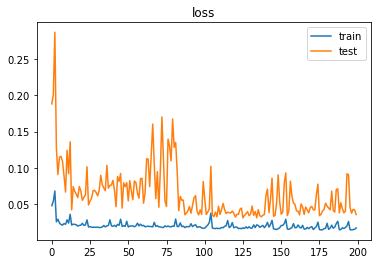

In [12]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('loss')
plt.show()

### 예측 결과 plot

In [13]:
features=[yhat,test_y]

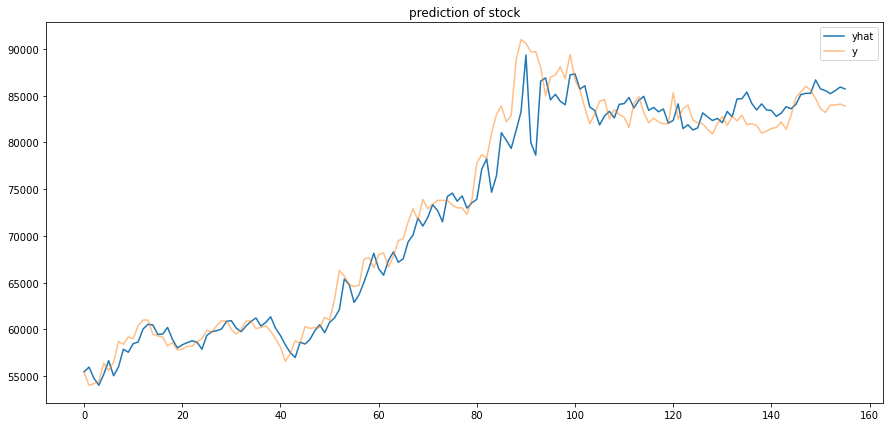

In [14]:
plt.figure(figsize=(15,7))
plt.title('prediction of stock')
plt.plot(yhat,label='yhat')
plt.plot(test_y,alpha=0.5,label='y')
plt.legend()
plt.show()